Computer: lintu.ucsd.edu


/usr/local/anaconda/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /usr/local/anaconda/lib/python2.7/argparse.pyc, but /usr/local/anaconda/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


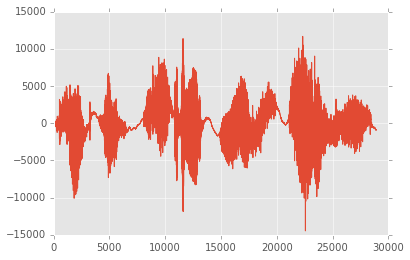

In [1]:
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
print 'Computer: ' + comp_name
if  comp_name == 'chim':
    sys.path.append('C:\Users\GentnerLab\Documents\Experiment\scripts\sound_tools')
    experiment_folder = os.path.join('C:\Users\GentnerLab\Documents\Experiment')
    r = os.path.join('C:\Users\GentnerLab\Documents\Experiment')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')

if 'lintu' in comp_name:
    sys.path.append('/mnt/cube/earneodo/repos/soundflow/sound_tools')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')
    raw_data_folder = os.path.join(experiment_folder, 'raw_data')
#test soundtools
from soundtools import WavData, Chunk
    
#file structure
bird_id = 'z002'
sess = 4
rec = 'a'
run = 2
bout = '4369_020'

raw_file_folder = os.path.join(raw_data_folder, bird_id, str(sess).zfill(3))
raw_file_name = rec + '_' + str(run).zfill(2) + '_song.wav'
if bout is not None:
    raw_file_folder = os.path.join(raw_file_folder, 'bouts')
    raw_file_name = rec + '_' + str(run).zfill(2) + '_song_' + bout + '.wav'
raw_file_path = os.path.join(raw_file_folder, raw_file_name)
sound = WavData(raw_file_path)


#get a piece, filter it, plot it
window_t = 234700 #time window in msec
window_size = 1000 # window len in msec

window_t_samples = int(round(window_t*sound.s_f/1000.))
window_samples = int(round(window_size*sound.s_f/1000.))
window_samples = min(window_samples, sound.n_samples - window_t_samples)


if bout is not None:
    segment = [0, None]
else:
    segment=[window_t_samples, window_t_samples + window_samples]

window = Chunk(sound, segment=segment)
plt.plot(np.transpose(window.data))
# window2 = window2 = Chunk(sound, segment=segment, chan_list = [0, 1])
# plt.plot(np.transpose(window2.data));

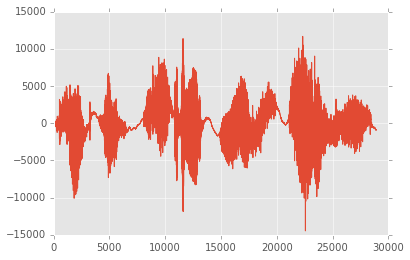

In [2]:
window = Chunk(sound)
plt.plot(np.transpose(window.data))

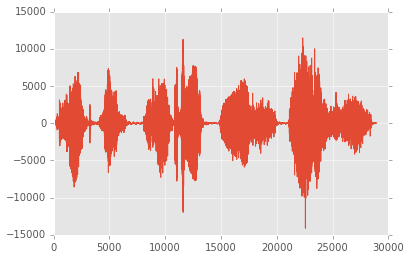

In [3]:
#filter the signal
s_f = window.sound.s_f

filt_lo = 22000 #Hz
filt_hi = 100 #Hz
hp_b, hp_a = sg.butter(4, filt_hi/(s_f/2.), btype='high')
lp_b, lp_a = sg.butter(4, filt_lo/(s_f/2.), btype='low')

def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt
    
window.apply_filter(band_pass_filter, hp_b, hp_a, lp_b, lp_a)
plt.plot(np.transpose(window.data))

In [4]:
# variables and parameters
y = window.data[0,:]
fs = window.sound.s_f
t = np.arange(0,y.shape[0], dtype=np.float)/fs

n_window = 1024
n_overlap = n_window-1
sigma = 7./1000.*fs

# pad the window so the output is the same size as the input
assert(n_window%2 == 0)
before_padding = n_window/2
after_padding = n_window/2 -1 
x = np.pad(y, (before_padding, after_padding), 'constant', constant_values = (0,0))

# Get the spectrogram of the padded segment
# overlap is n_window - 1, so that it slides across each time point
# window is gaussian so it ends up doing a sliding gabor transform, which is what I need to compute the fundamental
# f, t, Sxx = sg.spectrogram(x, fs, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')

# ax1 = plt.subplot(311)
# plt.plot(t, y)
# plt.subplot(212, sharex=ax1)
# plt.pcolormesh(t, f, np.log(Sxx))
# plt.ylim(0, 7000)

# plt.show()



In [5]:
def pad_input(sliding_func):
    def out_padded(*args, **kwargs):
        n_window = kwargs['nperseg']
        n_overlap = kwargs['noverlap']
        
        # pad the window so the output is the same size as the input
        assert(n_window%2 == 0)
        before_padding = n_window/2
        after_padding = n_window/2 -1 
        x = np.pad(args[0], (before_padding, after_padding), 'constant', constant_values = (0,0))
        # make the new input to the function
        args = (x,) + args[1:]
        return sliding_func(*args, **kwargs)
    
    return out_padded

from scipy.signal import spectrogram

spectrogram = pad_input(spectrogram)

f, t, Sxx = spectrogram(y, fs, nperseg = n_window, noverlap=n_overlap, window = sg.gaussian(n_window, sigma), scaling='spectrum')

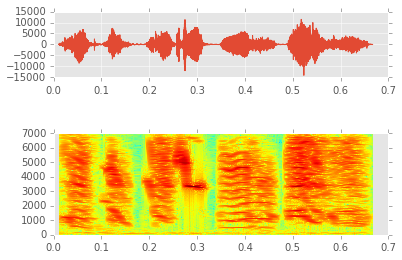

In [7]:
ax1 = plt.subplot(311)
plt.plot(t, y)
plt.subplot(212, sharex=ax1)
plt.pcolormesh(t, f, np.log(Sxx))
plt.ylim(0, 7000)

plt.show()

In [7]:
print y.shape
print t.shape
print Sxx.shape

(28901,)
(28901,)
(513, 28901)


In [25]:
span_before = np.zeros((513,2))
span_before.shape
a = np.ones((2,3))
np.hstack((a, np.zeros((2,2))))

array([[ 1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  1.,  0.,  0.]])

In [17]:
np.zeros((2,2))

array([[ 0.,  0.],
       [ 0.,  0.]])

In [6]:
# Now compute the fundamental across the spectrogram
pitch_list = [get_f0(n_slice, f, Sxx, f_range=[300, 6000], pow_thresh = 1000)[0] for n_slice in range(0, t.shape[0])]
plt.plot(pitch_list)

NameError: name 'get_f0' is not defined

In [ ]:
fr = np.array(pitch_list, dtype=np.int)

sz = y.shape[0]
for i in range(0, sz-350):
    if fr[i]==0 and fr[i+1]==0 and fr[i-1]>0:
        for j in range(0, 350):
            fr[i+j] = 0
            fr[i-j] = 0


for i in range(0, sz-100):
    sumarfrec = 0
    contador = 1
    for j in range(0, 100):
        if fr[i] > 0:
            sumarfrec = sumarfrec + fr[i+j]
            if fr[i+j] > 0:
                contador = contador + 1
    fr[i] = sumarfrec/(contador * 1.)

plt.plot(pitch_list)
plt.plot(fr)

In [ ]:
point = 14900
plt.plot(pitch_list)
plt.plot(point, pitch_list[point], '*')

In [ ]:
plt.figure(figsize=(10, 15))
ax1 = plt.subplot(311)
plt.plot(t, y)
plt.subplot(312, sharex=ax1)
plt.pcolormesh(t, f, np.log(Sxx))
plt.ylim(0, 7000)
plt.subplot(313, sharex=ax1)
#plt.plot(t, pitch_list)
plt.plot(t, fr)
plt.show()


In [ ]:
# Compute the fundamental in one spectral slice
t_slice = 180
n_slice = int(round(t_slice*fs/1000.))
n_slice = point

search_slice = (f>450) & (f<6000)

plt.plot(f, Sxx[:, n_slice])
#plt.plot(f[search_slice][peak_ind], Sxx[search_slice, n_slice][peak_ind], 'x')
plt.xlim(0, 6000)

f0, p0 = get_f0(n_slice, f, Sxx, f_range=[400, 6000], pow_thresh = 1200)
plt.plot(f0, p0, 'o')


In [ ]:
p0

In [ ]:
print get_f0(n_slice, f, Sxx, f_range=[450, 6000])[0]

In [ ]:
# Compute the fundamental on a spectral slice
def get_f0(t_n, f, sp_matrix, f_range = [0, None], pow_thresh = 12000):
    
    f_slice = f > f_range[0]
    if f_range[1] is not None:
        f_slice = f_slice & (f < f_range[1])
    
    peaks_ind = sg.find_peaks_cwt(sp_matrix[f_slice, t_n], np.arange(0.1,0.5))
    
    relevant_peaks = np.where(sp_matrix[f_slice, t_n][peaks_ind] > pow_thresh)[0]

    if not relevant_peaks.shape[0] == 0:
        first_peak = relevant_peaks[0]
        f_0 = f[f_slice][peaks_ind][first_peak]
        p_0 = Sxx[f_slice, t_n][peaks_ind][first_peak]
    else:
        f_0 = 0
        p_0 = 0

    
    return f_0, p_0

In [ ]:
12000*12000